In [1]:
using Plots
using DataStructures
using LinearAlgebra

In [2]:
using ReverseDiff

In [22]:
n = 36
w0 = rand((4 * n) + (n * n) + (n * 1) + n + n + 1) * 1 .- 0.5;

In [4]:
function relu(x)
    return max(0, x)
end

function Q(wb, x_in)
    """
    A nnet of shape (4, n) -> (n, n) -> (n, 1)
    """
    W1 = reshape(wb[begin:4 * n], (4, n))
    W2 = reshape(wb[4 * n : n * n + 4 * n - 1], (n, n))
    W3 = reshape(wb[n * n + 4 * n: n * n + 4 * n + n * 1 - 1], (n, 1))
    nb1 = n * n + 4 * n + n * 1
    nb2 = n * n + 4 * n + n * 1 + n
    nb3 = n * n + 4 * n + n * 1 + 2 * n
    nb4 = n * n + 4 * n + n * 1 + 2 * n + 1
    b1 = reshape(wb[nb1:nb2 - 1], (1, n))
    b2 = reshape(wb[nb2:nb3 - 1], (1, n))
    b3 = wb[end]
    
    x_out = relu.(relu.(x_in * W1 .+ b1) * W2 .+ b2) * W3 .+ b3
    return x_out
end



Q (generic function with 1 method)

In [7]:
kappa, sigma, xbar = 5, 1.5, 1
eps = 0.8
dt = 0.01
phi = 0.5
T = 1
c = 0.01

0.01

In [8]:
function step_function(t, q, x, a; kappa, dt, phi)
    q_prime = q + a
    t_prime = t + dt
    
    z = sigma * (1 - exp(-2 * kappa * dt)) / (2 * kappa)
    x_prime= x * exp(-kappa * dt) + xbar * (1 - exp(-kappa * dt)) + z * randn()
    
    r = q_prime * (x_prime - x) - phi * a ^ 2
    if t >= T
        r = r - c * q_prime ^ 2
    end
        
    return r, x_prime, t_prime, q_prime
end

function insert_to_queue!(D, element)
    if length(D) == capacity(D)
        popfirst!(D)
        push!(D, element)
    else
        push!(D, element)
    end
end

function dq_loss(wb; D, action_space, qlim, gamma)
    loss = 0
    for (t, q, x, a, r, t_prime, q_prime, x_prime) in D
        Q_pred = Q(wb, [t q x a])
        
        inventory_space = -(qlim + q):(qlim - q)
        possible_actions = intersect(action_space, inventory_space)
        a_ix = map(a -> Q(w0, [t q x a])[1], possible_actions) 
        a_prime = possible_actions[argmax(a_ix)]
        
        Q_next = t_prime < T ? Q(wb, [t_prime q_prime x_prime a_prime]) : 0
        
        loss = loss + (r + gamma * Q_pred[1] - Q_next[1]) .^ 2
    end
    
    return loss
end

dq_loss (generic function with 1 method)

In [9]:
D = CircularDeque{NamedTuple}(1_000)
hist_loss = []
eps_min = 0.1
eps = 0.7
epsx = 1e-5
alpha = 0.00001
delta = 0.01
gamma = 0.7

action_limit = 5
qlim = 10
action_space = -action_limit:action_limit

-5:5

In [10]:
∇L = w -> ReverseDiff.gradient((w) -> dq_loss(w, D=D, action_space=action_space, qlim=qlim, gamma=gamma), w)

#9 (generic function with 1 method)

In [23]:
w0 = rand((4 * n) + (n * n) + (n * 1) + n + n + 1) * 1 .- 0.5;

In [12]:
using JLD
hist_loss = []
w0 = load("weights.jld", "data");

In [40]:
alpha = 1e-8

1.0e-8

In [ ]:
for it in 1:1_000
    x, t, a = 1 + 0.3 * rand() - 1/6, 0, 1
    q = 0

    while t < T
        inventory_space = -(qlim + q):(qlim - q)
        possible_actions = possible_actions = intersect(action_space, inventory_space)

        if rand() < eps
            a_ix = rand(1:length(possible_actions))
            a = possible_actions[a_ix]
        else
            a_ix = map(a -> Q(w0, [t q x a])[1], possible_actions) 
            a = possible_actions[argmax(a_ix)]
        end

        r, x_prime, t_prime, q_prime = step_function(t, q, x, a, kappa=kappa, dt=dt, phi=phi)
        to_buffer = (t=t, q=q, x=x, a=a, r=r, t_prime=t_prime, q_prime=q_prime, x_prime=x_prime)

        insert_to_queue!(D, to_buffer)
        t, q, x = t_prime, q_prime, x_prime

    end

    eps = max(eps - delta, eps_min)

    w0 = w0 .- (alpha * ∇L(w0))

    L = dq_loss(w0, D=D, action_space=action_space, qlim=qlim, gamma=gamma)
    append!(hist_loss, L)

    if it % 10 == 0
        println("$it: $L")
    else
        print("$it\r")
    end
end

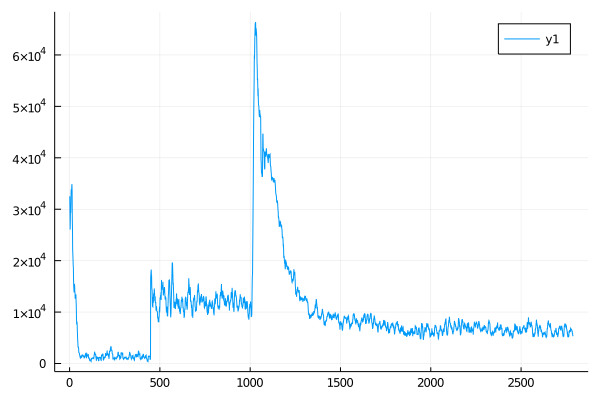

In [42]:
plot(hist_loss[10:end])

In [43]:
Q(w0, [[0.1 -5 0.9 -1]; [0.1 -5 0.9 1]])

2×1 Array{Float64,2}:
 -8.39761910507417
 -6.718137332009875

In [44]:
xmin, xmax, xstep = 0.8, 1.1, 0.01
S = Iterators.product(-10.:1:10., xmin:xstep:xmax, -5:1:5);
domain = Iterators.product(-10.:1:10., xmin:xstep:xmax);

In [45]:
# time - inventory - price - action 
Z_map = map(x -> Q(w0, [1 - dt x[1] x[2] x[3]])[1], vec(collect(S)))
Z_map = reshape(Z_map, size(S))
Z_map = mapslices(argmax, Z_map, dims=3)[:, :, 1]

21×31 Array{Int64,2}:
 10  10  10  10  10  10  10  10  10  …  10  10  10  10  10  10  10  10  10
  9   9   9   9   9   9   9   9   9      9   9   9   9   9   9   9   9   9
  9   9   9   9   9   9   9   9   9      9   9   9   9   9   9   9   9   9
  9   8   8   8   8   8   8   8   8      8   8   8   8   8   8   8   8   8
  8   8   8   8   8   8   8   8   8      8   8   8   8   8   8   8   8   8
  8   8   8   8   8   8   8   8   8  …   7   7   7   7   7   7   7   7   7
  7   7   7   7   7   7   7   7   7      7   7   7   7   7   7   7   7   7
  1   1   1   1   1   1   1   1   1      1   1   1   1   1   1   1   1   1
  1   1   1   1   1   1   1   1   1      1   1   1   1   1   1   1   1   1
  4   4   4   4   4   4   4   4   4      4   4   4   4   4   4   4   4   4
  5   5   5   5   5   5   5   5   5  …   5   5   5   5   5   5   5   5   5
  5   5   5   5   5   5   5   5   5      5   5   5   5   5   5   5   5   5
  5   5   5   5   5   5   5   5   5      5   5   5   5   5   5   5   5   5
  6

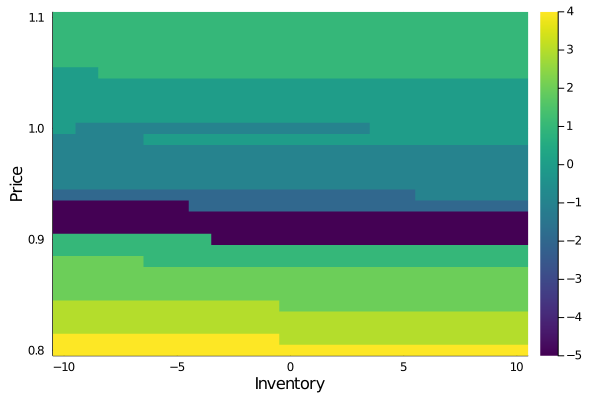

In [46]:
heatmap(-10:1:10, xmin:xstep:xmax, Z_map .- (action_limit .+ 1),
    xlabel="Inventory", ylabel="Price", c=:viridis,
)

In [138]:
using JLD
# save("weights.jld", "data", w0)

In [1070]:
# w0 = load("weights.jld", "data")

## Two conjectures:

1. We do not need millions of iterations
2. Final converge depends on defining a smooth function to undo the positions